In [1]:
from dataclasses import asdict
from pathlib import Path
import pickle

import fsspec
import matplotlib.pyplot as plt
import mlflow
import pandas as pd
import seaborn as sns

from nas import _REPO_ROOT
from nas.benchmark.nats_bench import ArchitectureResult

In [2]:
sns.set_theme()
sns.set_context("notebook")

In [3]:
TRACKING_URI = str(_REPO_ROOT / "results" / "mlruns")
TRACKING_URI

'/home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/nas/results/mlruns'

In [4]:
EXPERIMENT_NAME = "sa_zero_temperature"
EXPERIMENT_NAME

'sa_zero_temperature'

In [5]:
client = mlflow.tracking.MlflowClient(tracking_uri=TRACKING_URI)
client

In [6]:
selected_experiment = client.search_experiments(
    filter_string=f"name = '{EXPERIMENT_NAME}'"
)[0]
selected_experiment

<Experiment: artifact_location='file:///home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/nas/results/mlruns/604404612636862593', creation_time=1722849114405, experiment_id='604404612636862593', last_update_time=1722849114405, lifecycle_stage='active', name='sa_zero_temperature', tags={}>

In [7]:
selected_runs = client.search_runs(selected_experiment.experiment_id)
len(selected_runs)

100

In [8]:
run_df = pd.json_normalize([dict(selected_run.data) for selected_run in selected_runs])
run_df

,metrics.accuracy,metrics.time,metrics.final_time,metrics.control_parameter,metrics.loss,metrics.final_time_per_epoch,metrics.final_loss,metrics.transition,metrics.time_per_epoch,metrics.final_accuracy,...,params.benchmark__path,params.optimiser__number_iterations,params.seed,params.optimiser__cooling_schedule__type,params.results_dir,tags.mlflow.source.git.commit,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.runName
0,83.742,41.007152,41.007152,0.0,0.493861,3.417263,0.493861,0.0,3.417263,83.742,...,models/NATS-tss-v1_0-3ffb9-simple,1000,9,exponential,/home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/...,9a3fc2378cba47d8615f1a0991cf5f864bf7b826,tomaz,/home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/...,LOCAL,rebellious-bug-389
1,83.742,41.007152,41.007152,0.0,0.493861,3.417263,0.493861,0.0,3.417263,83.742,...,models/NATS-tss-v1_0-3ffb9-simple,900,9,exponential,/home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/...,9a3fc2378cba47d8615f1a0991cf5f864bf7b826,tomaz,/home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/...,LOCAL,nimble-goat-719
2,83.742,41.007152,41.007152,0.0,0.493861,3.417263,0.493861,0.0,3.417263,83.742,...,models/NATS-tss-v1_0-3ffb9-simple,800,9,exponential,/home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/...,9a3fc2378cba47d8615f1a0991cf5f864bf7b826,tomaz,/home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/...,LOCAL,honorable-carp-681
3,83.742,41.007152,41.007152,0.0,0.493861,3.417263,0.493861,0.0,3.417263,83.742,...,models/NATS-tss-v1_0-3ffb9-simple,700,9,exponential,/home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/...,9a3fc2378cba47d8615f1a0991cf5f864bf7b826,tomaz,/home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/...,LOCAL,unequaled-conch-318
4,83.742,41.007152,41.007152,0.0,0.493861,3.417263,0.493861,0.0,3.417263,83.742,...,models/NATS-tss-v1_0-3ffb9-simple,600,9,exponential,/home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/...,9a3fc2378cba47d8615f1a0991cf5f864bf7b826,tomaz,/home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/...,LOCAL,fearless-bee-888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,83.964,45.128714,45.128714,0.0,0.484066,3.760726,0.484066,0.0,3.760726,83.964,...,models/NATS-tss-v1_0-3ffb9-simple,500,0,exponential,/home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/...,9a3fc2378cba47d8615f1a0991cf5f864bf7b826,tomaz,/home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/...,LOCAL,rogue-ant-718
96,83.964,45.128714,45.128714,0.0,0.484066,3.760726,0.484066,0.0,3.760726,83.964,...,models/NATS-tss-v1_0-3ffb9-simple,400,0,exponential,/home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/...,9a3fc2378cba47d8615f1a0991cf5f864bf7b826,tomaz,/home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/...,LOCAL,silent-mole-808
97,83.964,45.128714,45.128714,0.0,0.484066,3.760726,0.484066,0.0,3.760726,83.964,...,models/NATS-tss-v1_0-3ffb9-simple,300,0,exponential,/home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/...,9a3fc2378cba47d8615f1a0991cf5f864bf7b826,tomaz,/home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/...,LOCAL,auspicious-lynx-500
98,83.964,45.128714,45.128714,0.0,0.484066,3.760726,0.484066,0.0,3.760726,83.964,...,models/NATS-tss-v1_0-3ffb9-simple,200,0,exponential,/home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/...,9a3fc2378cba47d8615f1a0991cf5f864bf7b826,tomaz,/home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/...,LOCAL,dapper-pig-582


In [9]:
run_df.columns

Index(['metrics.accuracy', 'metrics.time', 'metrics.final_time',
       'metrics.control_parameter', 'metrics.loss',
       'metrics.final_time_per_epoch', 'metrics.final_loss',
       'metrics.transition', 'metrics.time_per_epoch',
       'metrics.final_accuracy',
       'params.optimiser__cooling_schedule__decay_rate',
       'params.benchmark__edges_per_cell',
       'params.optimiser__cooling_schedule__length', 'params.results_base_dir',
       'params.benchmark__name', 'params.benchmark__dataset',
       'params.optimiser__algorithm',
       'params.optimiser__cooling_schedule__initial', 'params.experiment_name',
       'params.benchmark__path', 'params.optimiser__number_iterations',
       'params.seed', 'params.optimiser__cooling_schedule__type',
       'params.results_dir', 'tags.mlflow.source.git.commit',
       'tags.mlflow.user', 'tags.mlflow.source.name',
       'tags.mlflow.source.type', 'tags.mlflow.runName'],
      dtype='object')

In [10]:
selected_runs[0].info.artifact_uri

'file:///home/tomaz/git/Politecnico/Extra/AI-Tech-Lab/nas/results/mlruns/604404612636862593/339de08d5d004f0e97678a7c0cda1f9b/artifacts'

In [11]:
mlflow.artifacts.list_artifacts(
    selected_runs[0].info.artifact_uri, tracking_uri=TRACKING_URI
)

[<FileInfo: file_size=654, is_dir=False, path='artifacts/result.pkl'>]

In [12]:
run_results: list[ArchitectureResult] = []
for run in selected_runs:
    artifact_uri: str = run.info.artifact_uri
    with fsspec.open(Path(artifact_uri) / "result.pkl", "rb") as f:
        run_results.append(pickle.load(f))
run_results

[ArchitectureResult(index=11174, train=Metrics(loss=0.35361560778617857, accuracy=87.8699999963379, time_per_epoch=9.75358521938324, time=117.04302263259888), val=Metrics(loss=0.4938606442213058, accuracy=83.74200000854492, time_per_epoch=3.417262676216307, time=41.007152114595684), test=Metrics(loss=0.49730029714107515, accuracy=83.715, time_per_epoch=1.3669050704865227, time=16.402860845838273), flops=78.56193, size_parameters=0.559386, latency=0.014724364406184146),
 ArchitectureResult(index=11174, train=Metrics(loss=0.35361560778617857, accuracy=87.8699999963379, time_per_epoch=9.75358521938324, time=117.04302263259888), val=Metrics(loss=0.4938606442213058, accuracy=83.74200000854492, time_per_epoch=3.417262676216307, time=41.007152114595684), test=Metrics(loss=0.49730029714107515, accuracy=83.715, time_per_epoch=1.3669050704865227, time=16.402860845838273), flops=78.56193, size_parameters=0.559386, latency=0.014724364406184146),
 ArchitectureResult(index=11174, train=Metrics(loss=

In [13]:
result_df = pd.json_normalize(asdict(result) for result in run_results)
result_df

,index,flops,size_parameters,latency,train.loss,train.accuracy,train.time_per_epoch,train.time,val.loss,val.accuracy,...,test.loss,test.accuracy,test.time_per_epoch,test.time,architecture.edge_0_to_1,architecture.edge_0_to_2,architecture.edge_1_to_2,architecture.edge_0_to_3,architecture.edge_1_to_3,architecture.edge_2_to_3
0,11174,78.56193,0.559386,0.014724,0.353616,87.870,9.753585,117.043023,0.493861,83.742,...,0.497300,83.715,1.366905,16.402861,3,4,4,1,3,0
1,11174,78.56193,0.559386,0.014724,0.353616,87.870,9.753585,117.043023,0.493861,83.742,...,0.497300,83.715,1.366905,16.402861,3,4,4,1,3,0
2,11174,78.56193,0.559386,0.014724,0.353616,87.870,9.753585,117.043023,0.493861,83.742,...,0.497300,83.715,1.366905,16.402861,3,4,4,1,3,0
3,11174,78.56193,0.559386,0.014724,0.353616,87.870,9.753585,117.043023,0.493861,83.742,...,0.497300,83.715,1.366905,16.402861,3,4,4,1,3,0
4,11174,78.56193,0.559386,0.014724,0.353616,87.870,9.753585,117.043023,0.493861,83.742,...,0.497300,83.715,1.366905,16.402861,3,4,4,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,13325,117.88353,0.830426,0.020455,0.344022,88.324,11.526478,138.317736,0.484066,83.964,...,0.502142,83.425,1.504290,18.051486,1,3,3,2,1,3
96,13325,117.88353,0.830426,0.020455,0.344022,88.324,11.526478,138.317736,0.484066,83.964,...,0.502142,83.425,1.504290,18.051486,1,3,3,2,1,3
97,13325,117.88353,0.830426,0.020455,0.344022,88.324,11.526478,138.317736,0.484066,83.964,...,0.502142,83.425,1.504290,18.051486,1,3,3,2,1,3
98,13325,117.88353,0.830426,0.020455,0.344022,88.324,11.526478,138.317736,0.484066,83.964,...,0.502142,83.425,1.504290,18.051486,1,3,3,2,1,3


In [14]:
result_df.columns

Index(['index', 'flops', 'size_parameters', 'latency', 'train.loss',
       'train.accuracy', 'train.time_per_epoch', 'train.time', 'val.loss',
       'val.accuracy', 'val.time_per_epoch', 'val.time', 'test.loss',
       'test.accuracy', 'test.time_per_epoch', 'test.time',
       'architecture.edge_0_to_1', 'architecture.edge_0_to_2',
       'architecture.edge_1_to_2', 'architecture.edge_0_to_3',
       'architecture.edge_1_to_3', 'architecture.edge_2_to_3'],
      dtype='object')

In [15]:
result_df.describe()

,index,flops,size_parameters,latency,train.loss,train.accuracy,train.time_per_epoch,train.time,val.loss,val.accuracy,...,test.loss,test.accuracy,test.time_per_epoch,test.time,architecture.edge_0_to_1,architecture.edge_0_to_2,architecture.edge_1_to_2,architecture.edge_0_to_3,architecture.edge_1_to_3,architecture.edge_2_to_3
count,100.0000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,12404.1400,129.876618,0.912600,0.019374,0.324051,88.97576,12.429547,149.154563,0.471013,84.445200,...,0.486497,84.084600,1.614357,19.372285,2.570000,2.900000,2.490000,1.400000,2.200000,2.290000
std,2982.7662,25.233101,0.173386,0.001706,0.021753,0.78359,1.418967,17.027600,0.013059,0.464386,...,0.013512,0.606534,0.138360,1.660324,0.843933,0.703526,1.306511,0.666667,0.752101,1.007998
min,4141.0000,51.036810,0.372346,0.014724,0.302177,87.18000,9.753585,117.043023,0.458039,83.256000,...,0.470389,82.890000,1.295916,15.550993,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
25%,13325.0000,117.883530,0.830426,0.019357,0.302177,88.32400,11.526478,138.317736,0.458039,83.964000,...,0.470389,83.480000,1.504290,18.051486,3.000000,3.000000,3.000000,1.000000,2.000000,2.000000
50%,13714.0000,117.883530,0.830426,0.020343,0.314498,89.29200,11.817882,141.814588,0.466092,84.682000,...,0.489194,83.895000,1.561618,18.739420,3.000000,3.000000,3.000000,1.000000,2.000000,3.000000
75%,13714.0000,153.272970,1.073466,0.020343,0.344022,89.76600,14.030071,168.360855,0.484066,84.892000,...,0.498287,84.820000,1.757976,21.095715,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000
max,14174.0000,153.272970,1.073466,0.020455,0.371228,89.76600,14.030071,168.360855,0.499287,84.892000,...,0.510825,84.820000,1.757976,21.095715,3.000000,4.000000,4.000000,3.000000,3.000000,3.000000


<Axes: xlabel='index', ylabel='Count'>

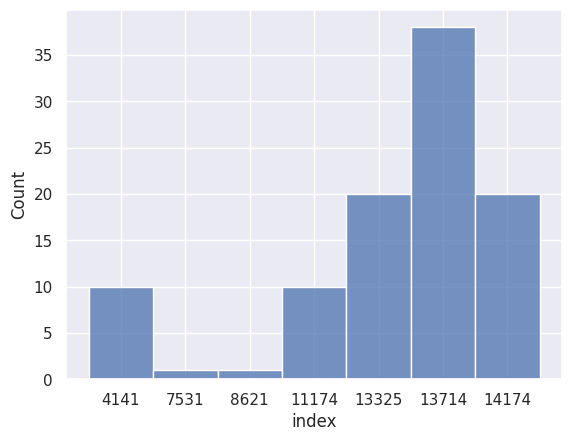

In [16]:
sns.histplot(result_df["index"].sort_values().astype("str"))

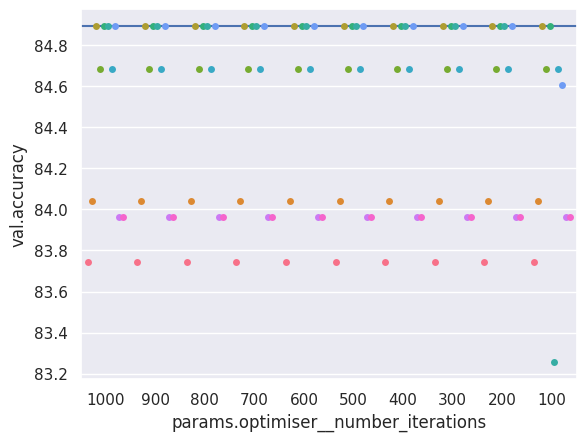

In [30]:
ax = plt.subplot()
sns.stripplot(
    result_df.join(run_df),
    x="params.optimiser__number_iterations",
    y="val.accuracy",
    hue="params.seed",
    palette="husl",
    dodge=True,
    jitter=False,
    legend=False,
    ax=ax,
)
ax.axhline(84.89199999023438)

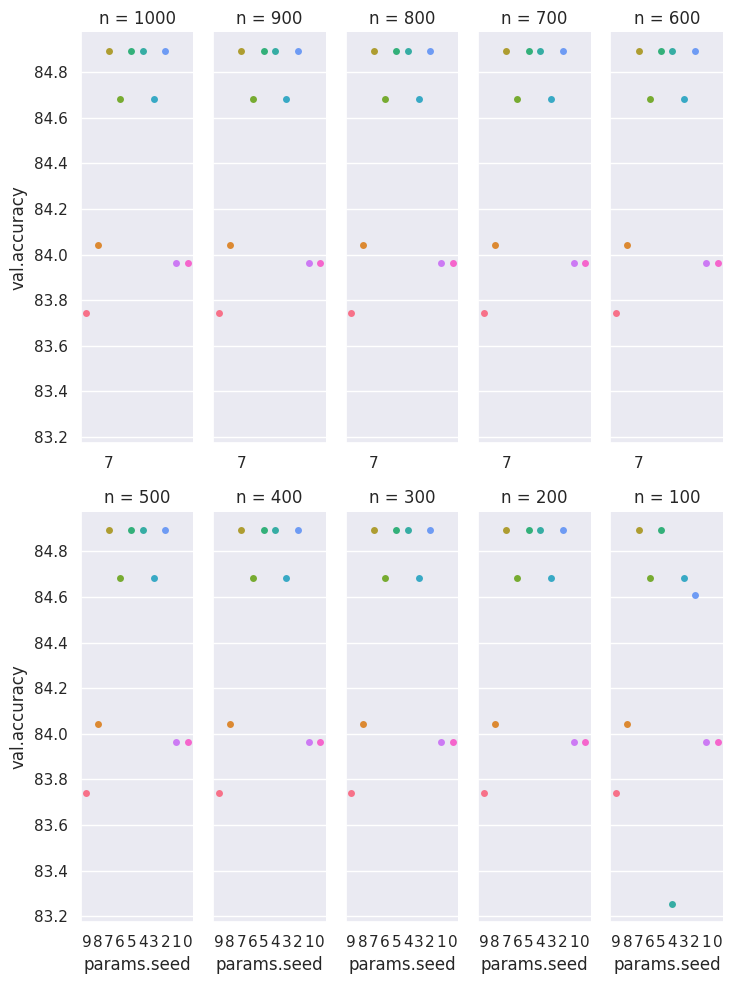

In [44]:
sns.catplot(
    result_df.join(run_df).rename(columns={"params.optimiser__number_iterations": "n"}),
    x="params.seed",
    y="val.accuracy",
    col="n",
    col_wrap=5,
    hue="params.seed",
    palette="husl",
    aspect=0.3,
    legend=False,
)

In [17]:
result_df["optimal_cifar10"] = result_df["index"] == 13714
result_df["optimal_cifar10"].mean()

0.38

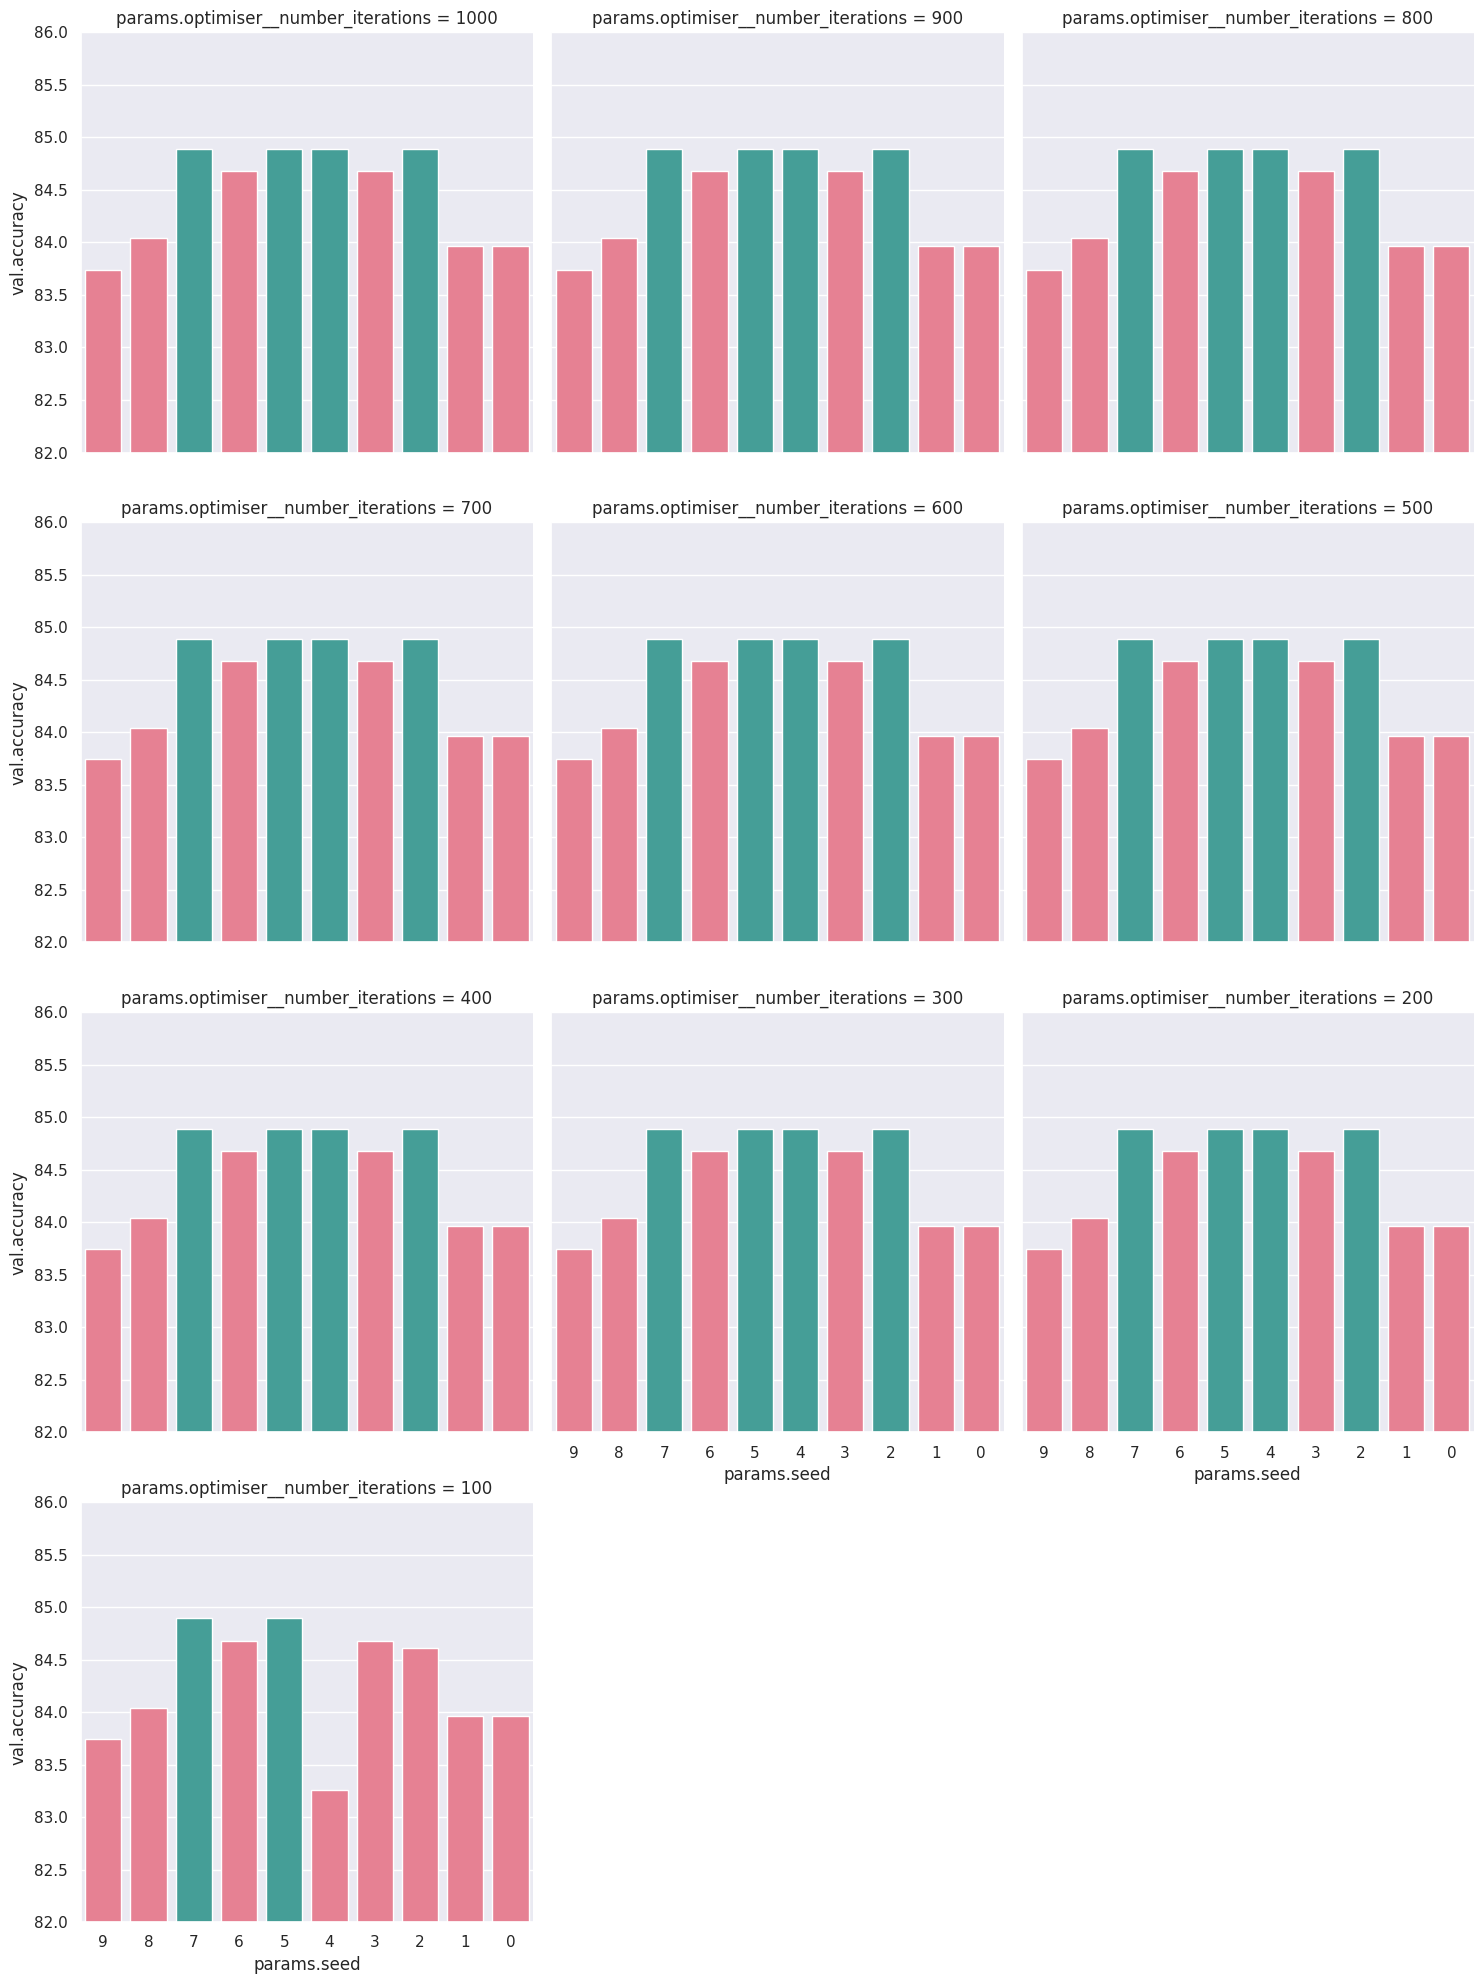

In [18]:
g = sns.FacetGrid(
    result_df.join(run_df),
    col="params.optimiser__number_iterations",
    col_wrap=3,
    ylim=(82, 86),
    height=5,
)
g.map_dataframe(
    sns.barplot,
    x="params.seed",
    y="val.accuracy",
    hue="optimal_cifar10",
    palette="husl",
)